In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
import os
os.getenv("LANGCHAIN_API_KEY")

'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'

In [3]:
os.environ['LANGSMITH_TRACING_V2']="true"
os.environ['LANGCHAIN_API_KEY']="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"


In [4]:
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_openai.chat_models import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [12]:

tools = [TavilySearchResults(max_results=1)]


In [14]:

from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools)


In [17]:
model = ChatOpenAI(temperature=0, streaming=True)

In [18]:
from langchain_core.utils.function_calling import convert_to_openai_function
functions = [convert_to_openai_function(t) for t in tools]
model = model.bind_tools(functions)

In [31]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [32]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage

In [46]:
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "continue"
    return "end"

def call_model(state):
    messages = state['messages']
    response = model.invoke(messages)
    return {"messages": [response]}

    


In [47]:
from langgraph.graph import StateGraph, END
workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue":"tools",
        "end": END
    }
)

workflow.add_edge("tools", "agent")

app = workflow.compile()

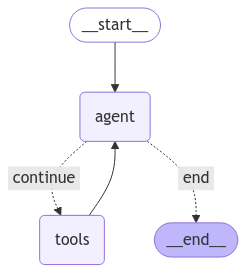

In [48]:
app

In [49]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is weather in kitchener, on?")]}
app.invoke(inputs)

{'messages': [HumanMessage(content='what is weather in kitchener, on?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_ilnOhInOIVU3Nj2v6rmrVARs', 'function': {'arguments': '{"query":"weather in Kitchener, ON"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-351966f7-d76d-4b08-9a62-d6902aec60ae-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Kitchener, ON'}, 'id': 'call_ilnOhInOIVU3Nj2v6rmrVARs', 'type': 'tool_call'}]),
  ToolMessage(content='[{"url": "https://www.weatherapi.com/", "content": "{\'location\': {\'name\': \'Kitchener\', \'region\': \'Ontario\', \'country\': \'Canada\', \'lat\': 43.45, \'lon\': -80.5, \'tz_id\': \'America/Toronto\', \'localtime_epoch\': 1739217696, \'localtime\': \'2025-02-10 15:01\'}, \'current\': {\'last_updated_epoch\': 173921760